In [1]:
import os.path
import pandapower.networks as pn
import pandapower as pp
import pandas as pd
import sympy as sym
import gurobipy as gp
from gurobipy import GRB
from numpy import flatnonzero as find, ones, zeros, Inf, pi, exp, conj, r_, arange, array
from pypower_.makeYbus import makeYbus
from pypower_.idx_brch import F_BUS, T_BUS, RATE_A, PF, QF, PT, QT, MU_SF, MU_ST
from pypower_.idx_gen import GEN_BUS, PG, QG
from pypower_.idx_cost import MODEL, PW_LINEAR, NCOST, POLYNOMIAL
from pypower_.totcost import totcost
from pypower_.makeSbus import makeSbus
from pypower_.idx_bus import BUS_TYPE, REF, VM, VA, MU_VMAX, MU_VMIN, LAM_P, LAM_Q
import cvxpy as cp
import numpy as np
from scipy.sparse import csr_matrix as sparse
from pypower_.idx_bus import PD, QD
from pypower_.idx_gen import GEN_BUS, PG, QG, GEN_STATUS

/home/huzuntao/PycharmProjects/MPP_Powersystem/venv/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import sys
print(sys.path)
print(os.path)
path_current = '/home/ubuntu-h/PycharmProjects/scientificProject'
if path_current not in sys.path:
    sys.path.insert(1, '/home/ubuntu-h/PycharmProjects/scientificProject')

['/home/huzuntao/PycharmProjects/MPP_Powersystem/notebooks', '/home/huzuntao/PycharmProjects/MPP_Powersystem', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/huzuntao/PycharmProjects/MPP_Powersystem/venv/lib/python3.8/site-packages', '/usr/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages']
<module 'posixpath' from '/usr/lib/python3.8/posixpath.py'>


In [3]:
import pandapower as pp
net = pp.create_empty_network()

# create buses
# bus1 = pp.create_bus(net, vn_kv=110.)
# bus2 = pp.create_bus(net, vn_kv=110.)
# bus3 = pp.create_bus(net, vn_kv=110.)
# # bus4 = pp.create_bus(net, vn_kv=110.)
# # bus5 = pp.create_bus(net, vn_kv=110.)
#
# # create 110 kV lines
# pp.create_line(net, bus2, bus3, length_km=70., std_type='149-AL1/24-ST1A 110.0')
# # pp.create_line(net, bus3, bus4, length_km=50., std_type="149-AL1/24-ST1A 110.0")
# # pp.create_line(net, bus4, bus2, length_km=40., std_type="149-AL1/24-ST1A 110.0")
# pp.create_line(net, bus1, bus2, length_km=70., std_type='149-AL1/24-ST1A 110.0')
#
# # create loads
# pp.create_load(net, bus1, p_mw=30., controllable=False)
# # pp.create_load(net, bus3, p_mw=70., controllable=False)
# # pp.create_load(net, bus4, p_mw=25., controllable=False)
#
# # create generators
# eg = pp.create_ext_grid(net, bus3, min_p_mw=0, max_p_mw=1000, vm_pu=1.05)
# g0 = pp.create_gen(net, bus2, p_mw=80, min_p_mw=0, max_p_mw=50, vm_pu=1.00, controllable=True)
# # g1 = pp.create_gen(net, bus4, p_mw=100, min_p_mw=0, max_p_mw=100, vm_pu=1.00, controllable=True)
#
#
# costeg = pp.create_poly_cost(net, 0, 'ext_grid', cp1_eur_per_mw=20)
# costgen1 = pp.create_poly_cost(net, 0, 'gen', cp1_eur_per_mw=10)
# costgen2 = pp.create_poly_cost(net, 1, 'gen', cp1_eur_per_mw=10)

bus1 = pp.create_bus(net, vn_kv=110.)
bus2 = pp.create_bus(net, vn_kv=110.)
bus3 = pp.create_bus(net, vn_kv=110.)
# bus4 = pp.create_bus(net, vn_kv=110.)
# bus5 = pp.create_bus(net, vn_kv=110.)

# create 110 kV lines
pp.create_line(net, bus2, bus3, length_km=90., std_type='149-AL1/24-ST1A 110.0')
# pp.create_line(net, bus3, bus4, length_km=50., std_type="149-AL1/24-ST1A 110.0")
# pp.create_line(net, bus4, bus2, length_km=40., std_type="149-AL1/24-ST1A 110.0")
pp.create_line(net, bus1, bus2, length_km=70., std_type='149-AL1/24-ST1A 110.0')

# create loads
pp.create_load(net, bus2, p_mw=50., controllable=False)
# pp.create_load(net, bus3, p_mw=70., controllable=False)
# pp.create_load(net, bus4, p_mw=25., controllable=False)

# create generators
eg = pp.create_ext_grid(net, bus3, min_p_mw=0, max_p_mw=50, vm_pu=1.05)
g0 = pp.create_gen(net, bus1, p_mw=50, min_p_mw=0, max_p_mw=50, vm_pu=1.00, controllable=True)
# g1 = pp.create_gen(net, bus4, p_mw=50, min_p_mw=0, max_p_mw=50, vm_pu=1.00, controllable=True)


costeg = pp.create_poly_cost(net, 0, 'ext_grid', cp1_eur_per_mw=20)
costgen1 = pp.create_poly_cost(net, 0, 'gen', cp1_eur_per_mw=10)
costgen2 = pp.create_poly_cost(net, 1, 'gen', cp1_eur_per_mw=10)

net.bus["min_vm_pu"] = 0.96
net.bus["max_vm_pu"] = 1.04
net.line["max_loading_percent"] = 100

![xx -w50](grid2GUROBI.png)

In [4]:
# net.bus["min_vm_pu"] = 0.98
# net.bus["max_vm_pu"] = 1.02
net.line["max_loading_percent"] = 100
# net.sn_mva = 100
# net = pp.networks.case14()
# net.gen['vm_pu'] = 1.0
# net.bus["min_vm_pu"] = 0.95
# net.bus["max_vm_pu"] = 1.05
# net.poly_cost[:,3] = 0
# net.poly_cost['cp2_eur_per_mw2'] = 0
net.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,ext_grid,0.0,20.0,0.0,0.0,0.0,0.0
1,0,gen,0.0,10.0,0.0,0.0,0.0,0.0
2,1,gen,0.0,10.0,0.0,0.0,0.0,0.0


In [5]:
om,ppopt = pp.runopp(net, delta=1e-16)   # solve the OPF problem

In [6]:
# net = pp.networks.case57()
print(net.res_gen)    # output the results of two generators
net.gen

        p_mw    q_mvar  va_degree  vm_pu
0  49.999987 -9.549766   7.409511   1.04


,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,None,0,50.0,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None,True,0.0,50.0,NaN


In [7]:
print(net.res_ext_grid)
net.ext_grid['vm_pu']

       p_mw    q_mvar
0  2.851905  9.940032


0    1.05
Name: vm_pu, dtype: float64

In [8]:
# the total cost of generation
net.res_cost

557.0379610412584

In [9]:
# the key variable, which represents the information of the OPF problem
om.get_ppc()

{'baseMVA': 1,
 'version': 2,
 'bus': array([[ 0.00000000e+00,  2.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  1.03999965e+00,  7.40951077e+00,
          1.10000000e+02,  1.00000000e+00,  1.04000000e+00,
          9.60000000e-01,  1.76706565e+01, -1.92365137e-21,
          2.85851760e+02,  0.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  5.00000000e+01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  1.01244732e+00,  4.32646488e-01,
          1.10000000e+02,  1.00000000e+00,  1.04000000e+00,
          9.60000000e-01,  1.98981272e+01,  8.74482757e-02,
          0.00000000e+00,  0.00000000e+00],
        [ 2.00000000e+00,  3.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  1.05000000e+00,  0.00000000e+00,
          1.10000000e+02,  1.00000000e+00,  1.05000000e+00,
          1.05000000e+00,  1.999996

In [10]:
## unpack data
ppc = om.get_ppc()
baseMVA, bus, gen, branch, gencost = \
    ppc["baseMVA"], ppc["bus"], ppc["gen"], ppc["branch"], ppc["gencost"]
vv, _, _, _ = om.get_idx()

## problem dimensions
nb = bus.shape[0]          ## number of buses
nl = branch.shape[0]       ## number of branches
ny = om.getN('var', 'y')   ## number of piece-wise linear costs, 'y' is a part of p-w linear costs

## bounds on optimization vars
x0, xmin, xmax = om.getv()

In [11]:
## build admittance matrices
Ybus, Yf, Yt = makeYbus(baseMVA, bus, branch)
Ybus.todense()

/home/huzuntao/PycharmProjects/MPP_Powersystem/pypower_/makeYbus.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  tap[i] = branch[i, TAP]  ## assign non-zero tap ratios
/usr/local/lib/python3.8/dist-packages/scipy/sparse/_coo.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  self.col = np.array(col, copy=copy, dtype=idx_dtype)


matrix([[ 162.99668368-343.31337094j, -162.99668368+344.47752737j,
            0.          +0.j        ],
        [-162.99668368+344.47752737j,  289.7718821 -609.74356413j,
         -126.77519842+267.92696573j],
        [   0.          +0.j        , -126.77519842+267.92696573j,
          126.77519842-266.43019318j]])

In [12]:
## Set the lower and upper bound for all variables
ll, uu = xmin.copy(), xmax.copy()
# print(f'll : {ll}; uu : {uu}')
ll[xmin == -Inf] = -1e10   ## replace Inf with numerical proxies
uu[xmax ==  Inf] =  1e10
Va_refs = bus[bus[:, BUS_TYPE]  == REF, VA] * (pi / 180)
# print(f"Va_refs: {Va_refs}")
ll[vv["i1"]["Va"]:vv["iN"]["Va"]] = -np.ones_like(bus[:, VA]) * (pi / 2) # Va lower bound 赋值
uu[vv["i1"]["Va"]:vv["iN"]["Va"]] = np.ones_like(bus[:, VA]) * (pi / 2) # Va upper bound 赋值
## deal with the Va_refs
ll[vv["i1"]["Va"]:vv["iN"]["Va"]][bus[:, BUS_TYPE]  == REF] = Va_refs  # Va_refs lower bound 赋值
uu[vv["i1"]["Va"]:vv["iN"]["Va"]][bus[:, BUS_TYPE]  == REF] = Va_refs # Va_refs upper bound 赋值
## deal with reactive power, whose ll and uu is 1e9
ll[ll<-1e4] = -100
uu[uu>1e4] = 100
v_max = uu[vv["i1"]["Vm"]:vv["iN"]["Vm"]][-1]
print(f'll"{ll};\n uu:{uu}')

ll"[-1.57079633e+00 -1.57079633e+00  0.00000000e+00  9.60000000e-01
  9.60000000e-01  1.05000000e+00 -1.00000000e-16 -1.00000000e-16
 -1.00000000e+02 -1.00000000e+02];
 uu:[  1.57079633   1.57079633   0.           1.04         1.04
   1.05        50.          50.         100.         100.        ]


In [13]:
x0[vv["i1"]["Vm"]:vv["iN"]["Vm"]]

array([1.  , 1.  , 1.05])

In [14]:
uu[vv["i1"]["Vm"]:vv["iN"]["Vm"]]

array([1.04, 1.04, 1.05])

In [15]:
bus[:, VM] # 赋值

array([1.03999965, 1.01244732, 1.05      ])

In [16]:
x0[vv["i1"]["Vm"]:vv["iN"]["Vm"]] = bus[:, VM] # 赋值

In [17]:
Va_refs = bus[bus[:, BUS_TYPE]  == REF, VA] * (pi / 180)
x0[vv["i1"]["Va"]:vv["iN"]["Va"]] = bus[:, VA] * (pi / 180) # 赋值

In [18]:
## 赋值
x0[vv["i1"]["Pg"]:vv["iN"]["Pg"]] = gen[:,PG]
x0[vv["i1"]["Qg"]:vv["iN"]["Qg"]] = gen[:,QG]


### 不能处理piecewise linear 的cost, 因为没有引入那个函数，（大约在这个位置）


### 处理cost fun

In [19]:
## grab Pg & Qg
Pg = x0[vv["i1"]["Pg"]:vv["iN"]["Pg"]]  ## active generation in p.u.
Qg = x0[vv["i1"]["Qg"]:vv["iN"]["Qg"]]  ## reactive generation in p.u.

##----- evaluate objective function -----
## polynomial cost of P and Q
# use totcost only on polynomial cost in the minimization problem formulation, pwl cost is the sum of the y variables.
ipol = find(gencost[:, MODEL] == POLYNOMIAL)   ## poly MW and MVAr costs
xx = r_[ Pg, Qg ] * baseMVA
if len(ipol)>0:
    f = sum( totcost(gencost[ipol, :], xx[ipol]) )  ## cost of poly P or Q
else:
    f = 0

In [20]:
Pg

array([ 2.85190462, 49.99998687])

In [21]:
xx[ipol]

array([ 2.85190462, 49.99998687])

In [22]:
First_Or_Con = 4
print(f"{gencost[ipol, First_Or_Con], gencost[:, First_Or_Con]}")

(array([20., 10.]), array([20., 10.]))


In [23]:
gencost

array([[ 2.,  0.,  0.,  2., 20.,  0.],
       [ 2.,  0.,  0.,  2., 10.,  0.]])

### 处理约束部分

In [24]:
## grab Pg & Qg
Pg = x0[vv["i1"]["Pg"]:vv["iN"]["Pg"]]  ## active generation in p.u.
Qg = x0[vv["i1"]["Qg"]:vv["iN"]["Qg"]]  ## reactive generation in p.u.

In [25]:
## put Pg & Qg back in gen
gen[:, PG] = Pg * baseMVA  ## active generation in MW
gen[:, QG] = Qg * baseMVA  ## reactive generation in MVAr

In [26]:

on = find(gen[:, GEN_STATUS] > 0)      ## which generators are on?
gbus = gen[on, GEN_BUS]                   ## what buses are they at?

## form net complex bus power injection vector
nb = bus.shape[0]
ngon = on.shape[0]
## connection matrix, element i, j is 1 if gen on(j) at bus i is ON
Cg = sparse((ones(ngon), (gbus, range(ngon))), (nb, ngon))

## power injected by gens plus power injected by loads converted to p.u.
Sbus = ( Cg * (gen[on, PG] + 1j * gen[on, QG]) - (bus[:, PD] + 1j * bus[:, QD]) ) / baseMVA
# Sbus = makeSbus(baseMVA, bus, gen) ## net injected power in p.u.

In [27]:
Sbus

array([ 49.99998687-9.54976553j, -50.        +0.j        ,
         2.85190462+9.94003228j])

In [28]:
## reconstruct V
Va = x0[vv["i1"]["Va"]:vv["iN"]["Va"]]
Vm = x0[vv["i1"]["Vm"]:vv["iN"]["Vm"]]
V = Vm * exp(1j * Va)
V

array([1.03131541+0.13411857j, 1.01241846+0.00764502j,
       1.05      +0.j        ])

In [29]:
Va

array([0.12932036, 0.00755111, 0.        ])

In [30]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar,lam_p,lam_q
0,1.040000,7.409511,-49.999987,9.549766,17.670657,-1.923651e-21
1,1.012447,0.432646,50.000000,0.000000,19.898127,8.744828e-02
2,1.050000,0.000000,-2.851905,-9.940032,19.999967,2.002148e-21


In [31]:
## evaluate power flow equations
mis = V * conj(Ybus * V) - Sbus

In [32]:
ppc['branch']

array([[ 1.00000000e+00+0.j,  2.00000000e+00+0.j,  1.44297521e-03+0.j,
         3.04958678e-03+0.j,  2.99354510e+00+0.j,  8.95470268e+01+0.j,
         2.50000000e+02+0.j,  2.50000000e+02+0.j,  1.00000000e+00+0.j,
         0.00000000e+00+0.j,  1.00000000e+00+0.j, -3.60000000e+02+0.j,
         3.60000000e+02+0.j, -2.66544126e+00+0.j, -1.27304181e+01+0.j,
         2.85190462e+00+0.j,  9.94003228e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  1.00000000e+00+0.j,  1.12231405e-03+0.j,
         2.37190083e-03+0.j,  2.32831286e+00+0.j,  8.95470268e+01+0.j,
         2.50000000e+02+0.j,  2.50000000e+02+0.j,  1.00000000e+00+0.j,
         0.00000000e+00+0.j,  1.00000000e+00+0.j, -3.60000000e+02+0.j,
         3.60000000e+02+0.j,  4.99999869e+01+0.j, -9.54976553e+00+0.j,
        -4.73345587e+01+0.j,  1.27304181e+01+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.

In [33]:
branch[:, RATE_A]

array([89.54702675+0.j, 89.54702675+0.j])

In [34]:
 ## find branches with flow limits
il = find((branch[:, RATE_A] != 0) & (branch[:, RATE_A] < 1e10))
nl2 = len(il)           ## number of constrained lines

In [35]:
il

array([0, 1])

In [36]:
Pg_lower, Pg_upper = ll[vv["i1"]["Pg"]:vv["iN"]["Pg"]], uu[vv["i1"]["Pg"]:vv["iN"]["Pg"]]

In [67]:
# Parameters
# obtain the complex load
Pd = bus[:, PD]
Qd = bus[:, QD]
flow_max = [8018.67,8018.67]
# slack_v = net.ext_grid['vm_pu']
Pg_lower, Pg_upper = ll[vv["i1"]["Pg"]:vv["iN"]["Pg"]], uu[vv["i1"]["Pg"]:vv["iN"]["Pg"]]*baseMVA
Qg_lower, Qg_upper = ll[vv["i1"]["Qg"]:vv["iN"]["Qg"]], uu[vv["i1"]["Qg"]:vv["iN"]["Qg"]]*baseMVA

def optimize_OPF(p_load):
    Pd = p_load
    Qd = 0
    # Pd = bus[:, PD]
    Qd = bus[:, QD]

    lb_update = -1e4

    # obtain the range of voltage; the range is from the setting
    V_range = 0.1
    V_ll,V_uu = 1.0-V_range, 1.0+V_range

    # create the model; set the model type: NonConvex.
    model = gp.Model("PowerGeneration");model.setParam('NonConvex', 2)
    model.setParam("LogToConsole", 0)

    # creat variables for the model; the numbers in the following codes should be replaced by parameters
    V_re = model.addMVar(3, lb=[-1.05,-1.05,-1.05], ub=[1.05,1.05,1.05], vtype=GRB.CONTINUOUS, name='V real')
    V_im = model.addMVar(3, lb=[-1.05,-1.05,-1.05],ub=[1.05,1.05,1.05], vtype=GRB.CONTINUOUS, name='V imag')
    # Pg = model.addMVar(2, lb=0, ub=[105,105], vtype=GRB.CONTINUOUS, name='Pg')
    # Qg = model.addMVar(2, lb=[0,0], ub=[105,105], vtype=GRB.CONTINUOUS, name='Qg')
    # temp1 = model.addMVar(3, lb=lb_update, vtype=GRB.CONTINUOUS, name='Temp 1')
    # temp2 = model.addMVar(3, lb=lb_update, vtype=GRB.CONTINUOUS, name='Temp 2')
    # Pg_net = model.addMVar(3, lb=lb_update, vtype=GRB.CONTINUOUS, name='Pg net')  # the number of buses, too
    # Qg_net = model.addMVar(3, lb=lb_update, vtype=GRB.CONTINUOUS, name='Qg net')

    Pg = model.addMVar(ngon, lb=Pg_lower, ub=Pg_upper, vtype=GRB.CONTINUOUS, name='Pg')
    Qg = model.addMVar(ngon, lb=Qg_lower, ub=Qg_upper, vtype=GRB.CONTINUOUS, name='Qg')
    temp1 = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Temp 1')
    temp2 = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Temp 2')
    Pg_net = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Pg net')  # the number of buses, too
    Qg_net = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Qg net')
    Line_temp_1 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 1')    # the shape should be line number
    Line_temp_2 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 2')    # the shape should be line number
    Line_temp_3 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 3')    # the shape should be line number
    Line_temp_4 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 4')    # the shape should be line number


    # the prameters of branches
    G = np.real(Ybus)
    B = np.imag(Ybus)
    # the parameters for currents in branches
    G_yf, B_yf = np.real(Yf), np.imag(Yf)
    G_yt, B_yt = np.real(Yt), np.imag(Yt)

    # Constraints; insert the formulas
    Temp_c1 = model.addConstr(G@V_re - B@V_im == temp1, 'Temp Constr 1')
    Temp_c2 = model.addConstr(G @ V_im + B @ V_re == temp2, 'Temp Constr 2')
    Pg_net_c = model.addConstr(Cg @ Pg - Pd == Pg_net, 'Pg net Constr')
    Qg_net_c = model.addConstr(Cg @ Qg - Qd == Qg_net, 'Qg net Constr')
    # print(f'Pd:{Pd}\n Qd:{Qd}')
    CVL_CPL = model.addConstrs((V_re[i] * temp1[i] *baseMVA+ V_im[i] * temp2[i]*baseMVA == Pg_net[i]  for i in range(nb)), 'Cvl P')  # break into different parts
    CVL_CPL_Q = model.addConstrs((V_im[i] * temp1[i] *baseMVA - V_re[i] * temp2[i]*baseMVA == Qg_net[i] for i in range(nb)), 'Cvl Q')


    V_slack = model.addConstr(V_re[2]==1.05, 'V slack real')
    V_slack_a = model.addConstr(V_im[2]==0, 'V slack imag')

    V_upper = model.addConstrs((V_re[i]**2 + V_im[i]**2 <= V_uu**2 for i in [0,1]), 'V upper bound')  # 对 range 起始值的处理，是处理树
    V_lower = model.addConstrs((V_re[i]**2 + V_im[i]**2 >= V_ll**2 for i in [0,1]), 'V lower bound')
    # Yf * W * Yf; the number is equal to that of the lines/branches
    Line_temp_c_1 = model.addConstr(G_yf@V_re - B_yf@V_im == Line_temp_1, 'Branch Con 1')
    Line_temp_c_2 = model.addConstr(G_yf @ V_im + B_yf @ V_re == Line_temp_2, 'Branch Con 2')
    Line_temp_c_3 = model.addConstr(G_yt@V_re - B_yt@V_im == Line_temp_3, 'Branch Con 3')
    Line_temp_c_4 = model.addConstr(G_yt @ V_im + B_yt @ V_re == Line_temp_4, 'Branch Con 4')
    # 下式左侧是否应该乘上baseMVA
    Line_c_1 = model.addConstrs((Line_temp_1[i]**2 + Line_temp_2[i]**2 <= np.real(flow_max[i]) for i in range(nl)), 'Branch Con 1') # p.u.
    Line_c_2 = model.addConstrs((Line_temp_3[i]**2 + Line_temp_4[i]**2 <= np.real(flow_max[i]) for i in range(nl)), 'Branch Con 2') # p.u.

    model.setObjective(np.array([1, 1.5])@Pg, GRB.MINIMIZE)

    # calculate the optimization
    model.optimize()

    Pg_star, Qg_star = Pg.X, Qg.X
    optimized_obj = np.array([1, 1.5])@Pg_star

    print(f'Pg: {Pg_star}; Qg: {Qg_star}; opt obj: {optimized_obj}')
    print(f'Ve: {V_re.X}; Vim: {V_im.X}; Pd: {Pd}')
    return Pg_star

optimize_OPF(p_load=20)

Set parameter NonConvex to value 2
Pg: [50.         11.26309034]; Qg: [-1.86774648 -1.01705257]; opt obj: 66.89463550245667
Ve: [0.99783147 1.009404   1.05      ]; Vim: [-0.10713049 -0.08743003  0.        ]; Pd: 20


array([50.        , 11.26309034])

In [69]:
i = 0
Pg_sta_list = []
for p in range(30, 95):
    i+=1
    p_load = np.array([0.0, p, 0.0])
    print(f'is: {i}')
    item = optimize_OPF(p_load)
    Pg_sta_list.append(item.tolist())

is: 1
Set parameter NonConvex to value 2
Pg: [3.12806545e+01 4.02402292e-09]; Qg: [-1.65647815 -1.19776981]; opt obj: 31.280654479327495
Ve: [1.0070134  1.00703044 1.05      ]; Vim: [-0.09084915 -0.09085918  0.        ]; Pd: [ 0. 30.  0.]
is: 2
Set parameter NonConvex to value 2
Pg: [3.23715575e+01 4.05760105e-09]; Qg: [-1.56594709 -1.08537882]; opt obj: 32.37155750795423
Ve: [1.00549607 1.00526832 1.05      ]; Vim: [-0.0940382  -0.09390315  0.        ]; Pd: [ 0. 31.  0.]
is: 3
Set parameter NonConvex to value 2
Pg: [3.34659311e+01 4.09217387e-09]; Qg: [-1.47190966 -0.96916419]; opt obj: 33.46593112663716
Ve: [1.003972   1.00349124 1.05      ]; Vim: [-0.09723959 -0.09695239  0.        ]; Pd: [ 0. 32.  0.]
is: 4
Set parameter NonConvex to value 2
Pg: [3.45638144e+01 4.12778125e-09]; Qg: [-1.37432326 -0.84908575]; opt obj: 34.56381444092764
Ve: [1.00244104 1.00169904 1.05      ]; Vim: [-0.10045356 -0.10000693  0.        ]; Pd: [ 0. 33.  0.]
is: 5
Set parameter NonConvex to value 2
Pg: [3

In [70]:
Pg_np = np.array(Pg_sta_list)
Pg_np[:,0]


array([31.28065447, 32.3715575 , 33.46593112, 34.56381443, 35.6652475 ,
       36.77027134, 37.878928  , 38.99126057, 40.10731323, 41.22713128,
       42.35076117, 43.47825057, 44.6096484 , 45.74500486, 46.88437152,
       48.02780131, 49.17534864, 49.99999999, 49.99999999, 49.99999999,
       49.99999999, 49.99999999, 49.99999999, 49.99999999, 49.99999999,
       49.99999999, 49.99999999, 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        , 50.        , 50.        , 50.        , 50.        ])

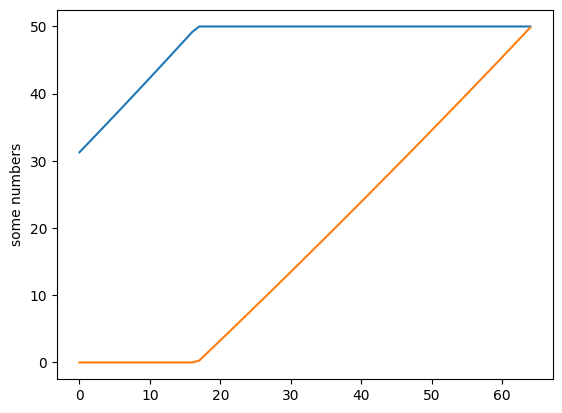

In [71]:
import matplotlib.pyplot as plt
plt.plot(Pg_np[:,0])
plt.plot(Pg_np[:,1])
plt.ylabel('some numbers')
plt.show()

In [ ]:
# V_re = model.addMVar(3, lb=[-1.05,-1.05,-1.05], ub=[1.05,1.05,1.05], vtype=GRB.CONTINUOUS, name='V real')
# V_im = model.addMVar(3, lb=[-1.05,-1.05,-1.05],ub=[1.05,1.05,1.05], vtype=GRB.CONTINUOUS, name='V imag')
# Pg = model.addMVar(2, lb=0, ub=[105,105], vtype=GRB.CONTINUOUS, name='Pg')
# Qg = model.addMVar(2, lb=[0,0], ub=[105,105], vtype=GRB.CONTINUOUS, name='Qg')

# Define the variables and parameters
V_re1, V_re2, V_re3 = sym.symbols('V_re1 V_re2 V_re3', real=True)
V_im1, V_im2, V_im3 = sym.symbols('V_im1 V_im2 V_im3', real=True)
Pg1, Pg2, Pg3 = sym.symbols('Pg1 Pg2 Pg3', real=True)
Qg1, Qg2, Qg3 = sym.symbols('Qg1 Qg2 Qg3', real=True)
# temp11, temp21 = sym.symbols('temp11 temp21')
# temp12, temp22 = sym.symbols('temp12 temp22')
# temp13, temp23 = sym.symbols('temp13 temp23')
Pg = sym.Matrix(['Pg2', 'Pg3' ])
Qg = sym.Matrix(['Qg2', 'Qg3' ])
# Pg_net = sym.MatrixSymbol('Pg_net', 3, 1)
Pd = sym.Symbol('Pd')
# Qg_net = sym.MatrixSymbol('Qg_net', 3, 1)
Qd = sym.MatrixSymbol('Qd', 3, 1)

# Constraints; insert the formulas
# Temp_c1 = model.addConstr(G@V_re - B@V_im == temp1, 'Temp Constr 1')
# Temp_c2 = model.addConstr(G @ V_im + B @ V_re == temp2, 'Temp Constr 2')
# Pg_net_c = model.addConstr(Cg @ Pg - Pd == Pg_net, 'Pg net Constr')
# Qg_net_c = model.addConstr(Cg @ Qg - Qd == Qg_net, 'Qg net Constr')
# # print(f'Pd:{Pd}\n Qd:{Qd}')
# CVL_CPL = model.addConstrs((V_re[i] * temp1[i] *baseMVA+ V_im[i] * temp2[i]*baseMVA == Pg_net[i]  for i in range(nb)), 'Cvl P')  # break into different parts
# CVL_CPL_Q = model.addConstrs((V_im[i] * temp1[i] *baseMVA - V_re[i] * temp2[i]*baseMVA == Qg_net[i] for i in range(nb)), 'Cvl Q')

# Define the quadratic equations

G = np.real(Ybus).todense().tolist()
B = np.imag(Ybus).todense().tolist()
for list in [G, B]:
    for i in range(3):
        for j in range(3):
            list[i][j] = int(list[i][j])
# for item in [eq1, eq2, eq3, eq4, eq5, eq6]:
#     item.subs({V_re3:1.05, V_im3:0, Pg3:0, Qd:[0,0,0], Pd[1]:0, Pd[2]:0})
V_re3, V_im3 = 1.05, 0
Pg3 = 0


temp11 = G[0][0]*V_re1 + G[0][1]*V_re2 + G[0][2]*V_re3 - (B[0][0]*V_im1 + B[0][1]*V_im2 + B[0][2]*V_im3)
temp12 = G[1][0]*V_re1 + G[1][1]*V_re2 + G[1][2]*V_re3 - (B[1][0]*V_im1 + B[1][1]*V_im2 + B[1][2]*V_im3)
temp13 = G[2][0]*V_re1 + G[2][1]*V_re2 + G[2][2]*V_re3 - (B[2][0]*V_im1 + B[2][1]*V_im2 + B[2][2]*V_im3)

temp21 = G[0][0]*V_im1 + G[0][1]*V_im2 + G[0][2]*V_im3 + (B[0][0]*V_re1 + B[0][1]*V_re2 + B[0][2]*V_re3)
temp22 = G[1][0]*V_im1 + G[1][1]*V_im2 + G[1][2]*V_im3 + (B[1][0]*V_re1 + B[1][1]*V_re2 + B[1][2]*V_re3)
temp23 = G[2][0]*V_im1 + G[2][1]*V_im2 + G[2][2]*V_im3 + (B[2][0]*V_re1 + B[2][1]*V_re2 + B[2][2]*V_re3)

Qg_net = Cg.todense()@Qg
Cg_ = Cg.todense().tolist() # Pg_net = Cg.todense()@Pg - [0, Pd, 0]
# Qg_net = Cg@Qg

eq1 = - (Cg_[0][0]*Pg1 + Cg_[0][1]*Pg3) + V_re1 * temp11 *baseMVA+ V_im1 * temp21*baseMVA
eq2 = - (Cg_[1][0]*Pg1 + Cg_[1][1]*Pg3) + V_re2 * temp12 *baseMVA+ V_im2 * temp22*baseMVA + Pd
eq3 = - (Cg_[2][0]*Pg1 + Cg_[2][1]*Pg3) + V_re3 * temp13 *baseMVA+ V_im3 * temp23*baseMVA

# eq4 = - Qg_net[0] + V_im1 * temp11 *baseMVA- V_re1 * temp21*baseMVA
# eq5 = - Qg_net[1] + V_im2 * temp12 *baseMVA- V_re2 * temp22*baseMVA
# eq6 = - Qg_net[2] + V_im3 * temp13 *baseMVA- V_re3 * temp23*baseMVA

# V_slack = model.addConstr(V_re[2]==1.05, 'V slack real')
# V_slack_a = model.addConstr(V_im[2]==0, 'V slack imag')
# for item in [eq1, eq2, eq3, eq4, eq5, eq6]:
#     item.subs({V_re3:1.05, V_im3:0, Pg3:0, Qd:[0,0,0], Pd[1]:0, Pd[2]:0})

# for item in [eq1, eq2, eq3]:
#     item.subs({V_re3:1.05, V_im3:0,V_re2:1.05, V_im2:0, Pg3:0, Qd:[0,0,0], Pd[1,0]:0, Pd[2,0]:0})
# eq1.subs({V_re3:1.05, V_im3:0,V_re2:1.05, V_im2:0, Pg3:0, Qd:[0,0,0], Pd[1,0]:0, Pd[2,0]:0})
# eq3.subs({V_re3:1.05, V_im3:0,V_re2:1.05, V_im2:0, Pg3:0, Qd:[0,0,0], Pd[1,0]:0, Pd[2,0]:0})
eq1.subs(Pg3, 0)
print(eq1)
print(eq2)
print(eq3)
# Solve the system of equations
sol = sym.solve([eq1, eq2, eq3], [Pg1,V_im2, V_re2, V_im1, V_re1])

# Print the solution
print(sol)

V_im1*(162*V_im1 - 162*V_im2 - 343*V_re1 + 344*V_re2) + V_re1*(343*V_im1 - 344*V_im2 + 162*V_re1 - 162*V_re2)
Pd + V_im2*(-162*V_im1 + 289*V_im2 + 344*V_re1 - 609*V_re2 + 280.35) + V_re2*(-344*V_im1 + 609*V_im2 - 162*V_re1 + 289*V_re2 - 132.3)
-1.0*Pg1 - 280.35*V_im2 - 132.3*V_re2 + 138.915


In [42]:
Cg

<3x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
A = sym.MatrixSymbol('A', 2, 2)
B = sym.MatrixSymbol('B', 2,1 )
C= A*B
C[1]

In [ ]:
Pg_lower, Pg_upper = ll[vv["i1"]["Pg"]:vv["iN"]["Pg"]], uu[vv["i1"]["Pg"]:vv["iN"]["Pg"]]
Pg_upper

In [ ]:
G
B

In [ ]:
Pd = bus[:, PD]
Pd

In [ ]:
baseMVA

In [ ]:
# Parameters
# obtain the complex load
Pd = bus[:, PD]
Qd = bus[:, QD]
slack_v = net.ext_grid['vm_pu']

lb_update = -1e4

# obtain the range of voltage; the range is from the setting
V_range = v_max - 1
V_ll,V_uu = 1.0-V_range, 1.0+V_range

# obtain the power range
Pg_lower, Pg_upper = ll[vv["i1"]["Pg"]:vv["iN"]["Pg"]], uu[vv["i1"]["Pg"]:vv["iN"]["Pg"]]*baseMVA
Qg_lower, Qg_upper = ll[vv["i1"]["Qg"]:vv["iN"]["Qg"]], uu[vv["i1"]["Qg"]:vv["iN"]["Qg"]]*baseMVA

# the dimension of the OPF
nb = bus.shape[0]          ## number of buses
nl = branch.shape[0]       ## number of branches

ineq_idx = 0

# create the model; set the model type: NonConvex.
model = gp.Model("PowerGeneration");model.setParam('NonConvex', 2)

# creat variables for the model; the numbers in the following codes should be replaced by parameters
V_re = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='V real')
V_im = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='V imag')
Pg = model.addMVar(ngon, lb=Pg_lower, ub=Pg_upper, vtype=GRB.CONTINUOUS, name='Pg')
Qg = model.addMVar(ngon, lb=Qg_lower, ub=Qg_upper, vtype=GRB.CONTINUOUS, name='Qg')
temp1 = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Temp 1')
temp2 = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Temp 2')
Pg_net = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Pg net')  # the number of buses, too
Qg_net = model.addMVar(nb, lb=lb_update, vtype=GRB.CONTINUOUS, name='Qg net')
Line_temp_1 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 1')    # the shape should be line number
Line_temp_2 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 2')    # the shape should be line number
Line_temp_3 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 3')    # the shape should be line number
Line_temp_4 = model.addMVar(nl, lb=lb_update, vtype=GRB.CONTINUOUS, name='Line temp 4')    # the shape should be line number

# the prameters of branches
G = np.real(Ybus)
B = np.imag(Ybus)
# the parameters for currents in branches
G_yf, B_yf = np.real(Yf), np.imag(Yf)
G_yt, B_yt = np.real(Yt), np.imag(Yt)

# Constraints; insert the formulas
Temp_c1 = model.addConstr(G@V_re - B@V_im == temp1, 'Temp Constr 1')
Temp_c2 = model.addConstr(G @ V_im + B @ V_re == temp2, 'Temp Constr 2')
Pg_net_c = model.addConstr(Cg @ Pg - Pd == Pg_net, 'Pg net Constr')
Qg_net_c = model.addConstr(Cg @ Qg - Qd == Qg_net, 'Qg net Constr')
# print(f'Pd:{Pd}\n Qd:{Qd}')
CVL_CPL = model.addConstrs((V_re[i] * temp1[i] *baseMVA+ V_im[i] * temp2[i]*baseMVA == Pg_net[i]  for i in range(nb)), 'Cvl P')  # break into different parts
CVL_CPL_Q = model.addConstrs((V_im[i] * temp1[i] *baseMVA - V_re[i] * temp2[i]*baseMVA == Qg_net[i] for i in range(nb)), 'Cvl Q')

# the constraints of voltages on all buses; set the constraint for slack bus, then give the upper and lower constraints for other buses
V_slack = model.addConstr(V_re[0]==slack_v, 'V slack real')
V_slack_a = model.addConstr(V_im[0]==0, 'V slack imag')
# the upper&lower constraints for buses except for the slack bus
V_upper = model.addConstrs((V_re[i]**2 + V_im[i]**2 <= V_uu**2 for i in range(1,nb-ineq_idx)), 'V upper bound')  # 对 range 起始值的处理，是处理树状分层搜索的突破口；有一"减"，对应的有一"加"。
# if ineq_idx != 0:
#     V_upper = model.addConstrs((V_re[i]**2 + V_im[i]**2 == V_uu**2 for i in range(ineq_idx,nb)), 'V upper bound')
#
V_lower = model.addConstrs((V_re[i]**2 + V_im[i]**2 >= V_ll**2 for i in range(1,nb)), 'V lower bound')

# Yf * W * Yf; the number is equal to that of the lines/branches
Line_temp_c_1 = model.addConstr(G_yf@V_re - B_yf@V_im == Line_temp_1, 'Branch Con 1')
Line_temp_c_2 = model.addConstr(G_yf @ V_im + B_yf @ V_re == Line_temp_2, 'Branch Con 2')
Line_temp_c_3 = model.addConstr(G_yt@V_re - B_yt@V_im == Line_temp_3, 'Branch Con 3')
Line_temp_c_4 = model.addConstr(G_yt @ V_im + B_yt @ V_re == Line_temp_4, 'Branch Con 4')
# 下式左侧是否应该乘上baseMVA
Line_c_1 = model.addConstrs((Line_temp_1[i]**2 + Line_temp_2[i]**2 <= np.real(flow_max[i]) for i in range(nl)), 'Branch Con 1') # p.u.
Line_c_2 = model.addConstrs((Line_temp_3[i]**2 + Line_temp_4[i]**2 <= np.real(flow_max[i]) for i in range(nl)), 'Branch Con 2') # p.u.

# set the objective of the model
print('ipol:', ipol)
# The "gencost" changes with different cases. Keep in Mind!
# model.setObjective(gencost[ipol, First_Or_Con]@Pg**2+gencost[ipol, First_Or_Con+1]@Pg, GRB.MINIMIZE)
model.setObjective(gencost[ipol, First_Or_Con]@Pg, GRB.MINIMIZE)

# calculate the optimization
# model.optimize()
model.X[:14]

Pg_star, Qg_star = Pg.X, Qg.X
optimized_obj = gencost[ipol, First_Or_Con]@Pg_star


In [ ]:
len(model.getVars())
len(model.getConstrs())

In [ ]:
print(Pg)

In [ ]:
net.res_bus

In [ ]:
m = gp.Model("model")
# x = m.addMVar(shape=(10), name="x")
y = m.addMVar(shape=(5),lb=np.array([-1,-2,-3,-4,-5]), name="y")

A = np.ones(5)

m.addConstrs((y[i] >=np.array([-1,-2,-3,-4,-5])[i] for i in range(5)), name="const")
m.setObjective(A@Y_.real)
m.optimize()

In [ ]:
m.X

In [ ]:
for v in m.getVars():
    print(v.varName, v.x)

In [ ]:
n = 3
p = 3
np.random.seed(1)
C = np.random.randn(n, n)
A = []
b = []
for i in range(p):
    A.append(np.random.randn(n, n))
    b.append(np.random.randn())

print(f'A ;{A};\n b : {b}')

In [ ]:
# Define and solve the CVXPY problem.
# Create a symmetric matrix variable
X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [X >> 0]
constraints += [
    cp.trace(A[i] @ X) == b[i] for i in range(p)
]
prob = cp.Problem(cp.Minimize(cp.trace(C @ X)),
                  constraints)
prob.solve()
# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)